In [1]:
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
with open('models_results.json', 'r') as f:
    llm_labels = json.load(f)

In [3]:
LABELS = ['NEUTRAL', 'NEGATIVE', 'POSITIVE']

In [4]:
import collections
separate_llm_labels = collections.defaultdict(lambda : [np.nan]*3500)
def decode_label(value):
    for p in LABELS:
        if p in value:
            return p
    raise ValueError(value)
    
for key, value in llm_labels.items():
    value = decode_label(value)
    model_name, idx = key.split('__')
    idx = int(idx)
    separate_llm_labels[model_name][idx] = value
llm_df = pd.DataFrame(separate_llm_labels)
llm_df = llm_df[~llm_df.isna().any(axis=1)]

In [5]:
assert (llm_df.index == range(len(llm_df))).all()

In [6]:
llm_df.head()

,gemini-1.5-pro,gpt-4o,gpt-4o-mini,claude-3-5-sonnet-latest,claude-3-5-haiku-latest,gemini-1.5-flash
0,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL,NEGATIVE,NEUTRAL
1,NEGATIVE,NEUTRAL,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE
2,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE
3,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL
4,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE


In [48]:
llm_df.shape

(2043, 9)

In [8]:
df_sent = pd.DataFrame(
    dict(
        text=pd.read_csv("data_small.csv", usecols=['text'])['text'],
        label=pd.read_csv('data_sent.csv', usecols=['label'])['label'].str.upper()
    )
)

In [9]:
def load_labels(df_sent):
    # copied from 010 nb
    test_data = []
    test_data_pseudo_label = []
    sub_data = {
    label: df_sent.text[df_sent.label == label].values for label in ["NEUTRAL", "POSITIVE", "NEGATIVE"]
    }
    for i in range(0, len(llm_df)):
        for label in ["NEUTRAL", "POSITIVE", "NEGATIVE"]:
            msg = sub_data[label][-i]
            test_data.append(msg)        
            test_data_pseudo_label.append(label)

    return pd.Series(test_data), pd.Series(test_data_pseudo_label)

In [10]:
llm_df["text"], llm_df["nn"] = load_labels(df_sent)

In [11]:
llm_df.head()

,gemini-1.5-pro,gpt-4o,gpt-4o-mini,claude-3-5-sonnet-latest,claude-3-5-haiku-latest,gemini-1.5-flash,text,nn
0,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL,NEGATIVE,NEUTRAL,@VivekGRamaswamy Biden is backing them?,NEUTRAL
1,NEGATIVE,NEUTRAL,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,@Raymond26773481 @BillAckman @POTUS @KamalaHar...,POSITIVE
2,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,@glennbeck GOP led House controls FEMA spendin...,NEGATIVE
3,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL,@moneygurusumit Donald Trump -Crypto crypto......,NEUTRAL
4,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,@alexxistexxxas What a fucking Great Day yeste...,POSITIVE


In [22]:
MODELS = ['gemini-1.5-pro', 'gpt-4o', 'gpt-4o-mini',
       'claude-3-5-sonnet-latest', 'claude-3-5-haiku-latest',
       'gemini-1.5-flash', 'nn']

In [13]:
from collections import Counter
def f(cols):
    return Counter(cols.to_dict().values()).most_common()[0][0]
llm_df['common'] = llm_df.loc[:, MODELS].apply(f, axis=1)

In [14]:
llm_df.head()

,gemini-1.5-pro,gpt-4o,gpt-4o-mini,claude-3-5-sonnet-latest,claude-3-5-haiku-latest,gemini-1.5-flash,text,nn,common
0,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL,NEGATIVE,NEUTRAL,@VivekGRamaswamy Biden is backing them?,NEUTRAL,NEUTRAL
1,NEGATIVE,NEUTRAL,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,@Raymond26773481 @BillAckman @POTUS @KamalaHar...,POSITIVE,NEGATIVE
2,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,@glennbeck GOP led House controls FEMA spendin...,NEGATIVE,NEGATIVE
3,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL,@moneygurusumit Donald Trump -Crypto crypto......,NEUTRAL,NEUTRAL
4,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,@alexxistexxxas What a fucking Great Day yeste...,POSITIVE,POSITIVE


# Let's get to example
# Up to 5 examples for each type of label

In [49]:
for label in LABELS:
    mask = np.where(llm_df['common'] == label)[0]
    for i in range(3):
        i = np.random.choice(mask)
        print()
        print("#"*50)
        
        print(llm_df['text'].values[i])
        
        print("## labels ##")
        print("common:", label)
        print(llm_df.loc[i, MODELS])
        print("## endLabels ##")


##################################################
@ElonMuskOde By the way where are those who were going to leave USA if Donald Trump wins?
## labels ##
common: NEUTRAL
gemini-1.5-pro              NEGATIVE
gpt-4o                       NEUTRAL
gpt-4o-mini                 NEGATIVE
claude-3-5-sonnet-latest     NEUTRAL
claude-3-5-haiku-latest      NEUTRAL
gemini-1.5-flash             NEUTRAL
nn                           NEUTRAL
Name: 312, dtype: object
## endLabels ##

##################################################
@CassandraRules @MattWalshBlog And she videoed it? 🤔
## labels ##
common: NEUTRAL
gemini-1.5-pro              NEUTRAL
gpt-4o                      NEUTRAL
gpt-4o-mini                 NEUTRAL
claude-3-5-sonnet-latest    NEUTRAL
claude-3-5-haiku-latest     NEUTRAL
gemini-1.5-flash            NEUTRAL
nn                          NEUTRAL
Name: 192, dtype: object
## endLabels ##

##################################################
Donald Trump Defeats Kamala Harris to Win 2024 Ele

# Let's calculate accuracy and f1 scores

In [16]:
from sklearn.metrics import accuracy_score, f1_score

In [17]:
# !pip install seaborn

In [45]:
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, normalize=True, figsize = (10,7), fontsize=14, fig=None):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    normalize: bool
        Normalize values
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    if fig is None:
        fig = plt.figure(figsize=figsize)

    try:
        heatmap = sns.heatmap(df_cm, ax=fig, annot=True, fmt='.2f' if normalize else 'd')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    # heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    # heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    fig.set_xlabel('True label')
    fig.set_ylabel('Predicted label')
    # fig.ylabel('True label')
    # fig.xlabel('Predicted label')
    return fig

In [46]:
from sklearn.metrics import confusion_matrix

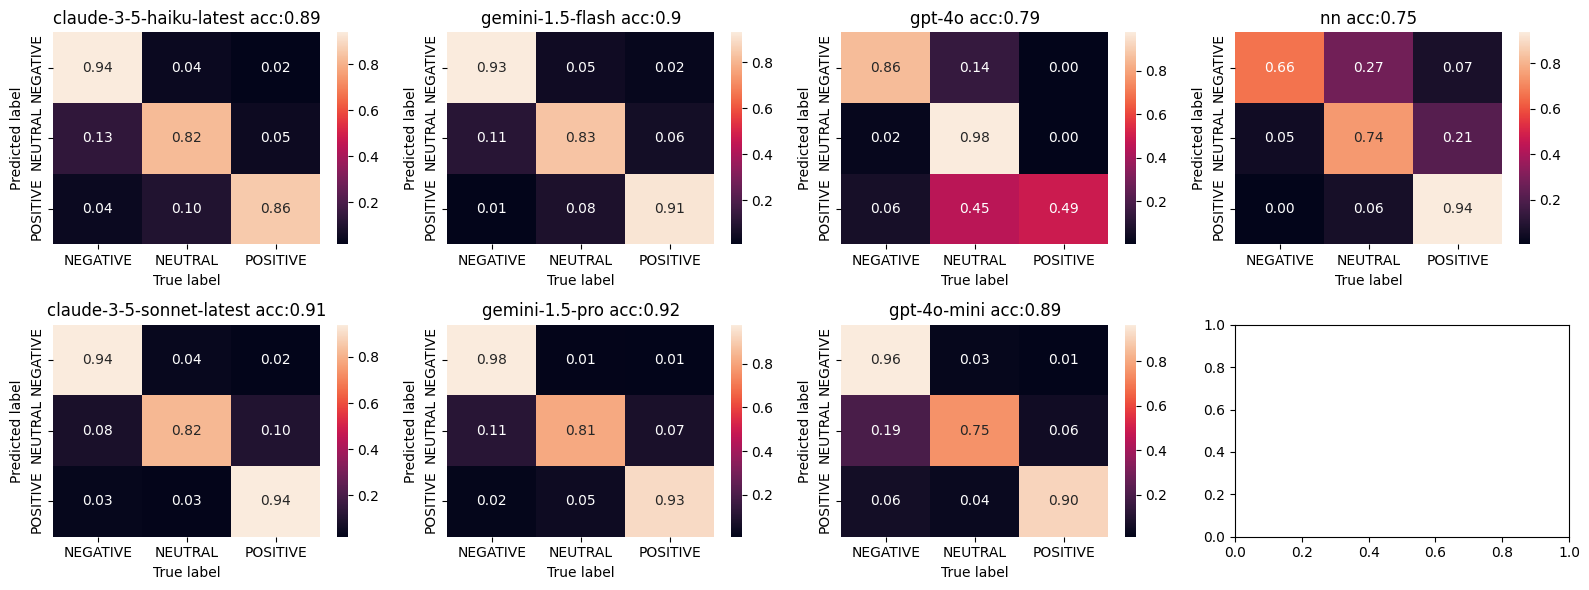

In [50]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 6))
for i, model in enumerate(sorted(MODELS)):
    ax[ i%2, i//2].set_title(model + " acc:"+ str(round(accuracy_score(llm_df['common'], llm_df[model]),2)))
    
    print_confusion_matrix(confusion_matrix(llm_df['common'], llm_df[model]), sorted(LABELS), figsize=(3, 3*7), fig=ax[ i%2, i//2])
fig.tight_layout()

plt.show()